# Single layer Neural Network

In this notebook, we will code a single neuron and use it as a linear classifier with two inputs. The tuning of the neuron parameters is done by backpropagation using gradient descent. When the activation function is the sigmoid, the model is equivalent to the logistic regression.

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

# matplotlib to display the data
import matplotlib
from matplotlib import pyplot as plt, cm
from matplotlib.colors import ListedColormap
%matplotlib inline

## Dataset

Let's create some labeled data in the form of (X, y) with an associated class which can be 0 or 1. For this we can use the function `make_blobs` in the `sklearn.datasets` module. Here we use 2 centers with coordinates (-0.5, -1.0) and (1.0, 1.0).

In [2]:
X, y = make_blobs(n_features=2, random_state=42, centers=[(-0.5, -1.0), (1.0, 1.0)])
y = y.reshape((y.shape[0], 1))
print(X.shape)
print(y.shape)

(100, 2)
(100, 1)


Plot our training data using `plt.scatter` to have a first visualization. Here we color the points with their labels stored in `y`.

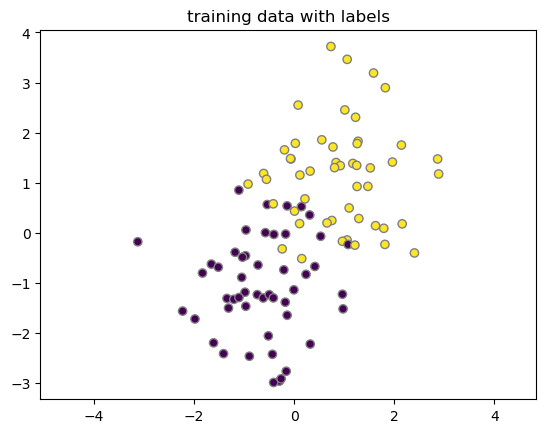

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), edgecolors='gray')
plt.title('training data with labels')
plt.axis('equal')
plt.show()

## Activation functions

Here we play with popular activation functions like tanh, ReLu or sigmoid.

In [4]:
def heaviside(x):
    return np.heaviside(x, np.zeros_like(x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def leaky_ReLU(x, alpha=0.1):
    return np.maximum(alpha * x, x)

def tanh(x):
    return np.tanh(x)

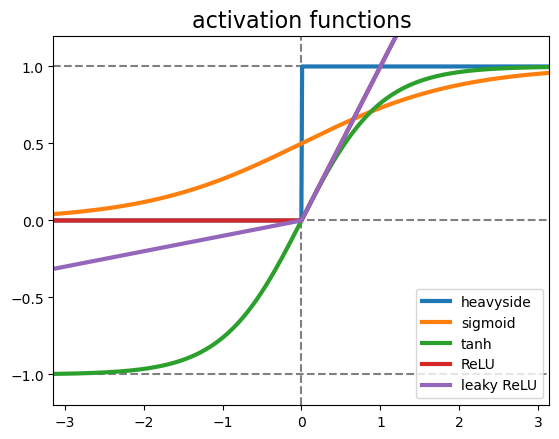

In [5]:
from math import pi

plt.figure()
x = np.arange(-pi, pi, 0.01)
plt.axhline(y=0., color='gray', linestyle='dashed')
plt.axhline(y=-1, color='gray', linestyle='dashed')
plt.axhline(y=1., color='gray', linestyle='dashed')
plt.axvline(x=0., color='gray', linestyle='dashed')

plt.xlim(-pi, pi)
plt.ylim(-1.2, 1.2)
plt.title('activation functions', fontsize=16)

plt.plot(x, heaviside(x), label='heavyside', linewidth=3)
legend = plt.legend(loc='lower right')
plt.savefig('activation_functions_1.pdf')
plt.plot(x, sigmoid(x), label='sigmoid', linewidth=3)
plt.legend(loc='lower right')
plt.savefig('activation_functions_2.pdf')
plt.plot(x, tanh(x), label='tanh', linewidth=3)
plt.legend(loc='lower right')
plt.savefig('activation_functions_3.pdf')
plt.plot(x, ReLU(x), label='ReLU', linewidth=3)
plt.legend(loc='lower right')
plt.savefig('activation_functions_4.pdf')
plt.plot(x, leaky_ReLU(x), label='leaky ReLU', linewidth=3)
plt.legend(loc='lower right')
plt.savefig('activation_functions_5.pdf')
plt.show()

In [7]:
# gradients of the activation functions
def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu_grad(x):
    return 1. * (x > 0)

def tanh_grad(x):
    return 1 - np.tanh(x) ** 2

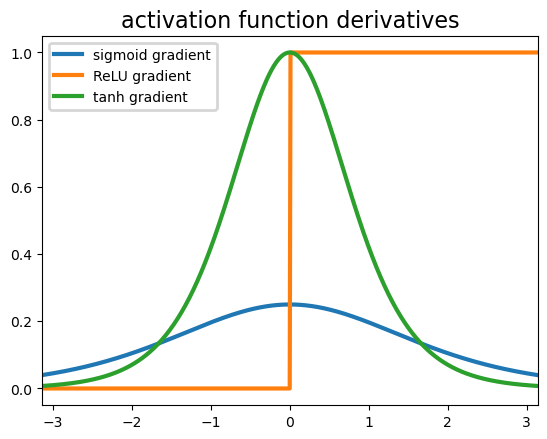

In [8]:
plt.figure()
x = np.arange(-pi, pi, 0.01)
plt.plot(x, sigmoid_grad(x), label='sigmoid gradient', linewidth=3)
plt.plot(x, relu_grad(x), label='ReLU gradient', linewidth=3)
plt.plot(x, tanh_grad(x), label='tanh gradient', linewidth=3)
plt.xlim(-pi, pi)
plt.title('activation function derivatives', fontsize=16)
legend = plt.legend()
legend.get_frame().set_linewidth(2)
plt.savefig('activation_functions_derivatives.pdf')
plt.show()

## ANN implementation

A simple neuron with two inputs $(x_1, x_2)$ which applies an affine transform of weigths $(w_1, w_2)$ and bias $w_0$.

The neuron compute the quantity called activation $a=\sum_i w_i x_i + w_0 = w_0 + w_1 x_1 + w_2 x_2$

This quantity is send to the activation function chosen to be a sigmoid function here: $f(a)=\dfrac{1}{1+e^{-a}}$

$f(a)$ is the output of the neuron bounded between 0 and 1.

### Quick implementation

First let's implement our network in a concise fashion.

In [14]:
import numpy as np
from numpy.random import randn

X, y = make_blobs(n_samples= 100, n_features=2, random_state=42, centers=[[-0.5, -1], [1, 1]])
# adjust the sizes of our arrays
X = np.c_[np.ones(X.shape[0]), X]
print(X.shape)
y = y.reshape((y.shape[0], 1))

np.random.seed(2)
W = randn(3, 1)
print('* model params: {}'.format(W.tolist()))
eta = 1e-2  # learning rate
n_epochs = 50

print(' epoch | Loss')
print('--------------')
for t in range(n_epochs):
    # forward pass
    y_pred = sigmoid(X.dot(W))
    loss = np.sum((y_pred - y) ** 2)
    if t % 5 == 0:
        print('%5d  | %5.2f' % (t, loss))

    # backprop
    grad_y_pred = 2 * (y_pred - y)
    grad_W = np.dot(X.T, grad_y_pred * y_pred * (1 - y_pred))

    # update rule
    W -= eta * grad_W
print('* new model params: {}'.format(W.tolist()))


(100, 3)
* model params: [[-0.4167578474054706], [-0.056266827226329474], [-2.136196095668454]]
 epoch | Loss
--------------
    0  | 69.89
    5  | 56.78
   10  | 26.71
   15  | 10.92
   20  |  8.45
   25  |  7.46
   30  |  6.93
   35  |  6.61
   40  |  6.40
   45  |  6.25
* new model params: [[-0.25594816136763526], [1.3472482576843752], [1.3640333350148732]]


### Modular implementation

Now let's create a class to represent our neural network to have more flexibility and modularity. This will prove to be useful later when we add more layers.

In [34]:
class SingleLayerNeuralNetwork:
    """A simple artificial neuron with a single layer and two inputs. 
    
    This type of network is called a Single Layer Neural Network and belongs to 
    the Feed-Forward Neural Networks. Here, the activation function is a sigmoid, 
    the loss is computed using the squared error between the target and 
    the prediction. Learning the parameters is achieved using back-propagation 
    and gradient descent
    """
    
    def __init__(self, eta=0.01, rand_seed=42):
        """Initialisation routine."""
        np.random.seed(rand_seed)
        self.W = np.random.randn(3, 1)  # weigths
        self.eta = eta  # learning rate
        self.loss_history = []
    
    def sigmoid(self, x):
        """Our activation function."""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_grad(self, x):
        """Gradient of the sigmoid function."""
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def predict(self, X, bias_trick=True):
        X = np.atleast_2d(X)
        if bias_trick:
            # bias trick: add a column of 1 to X
            X = np.c_[np.ones((X.shape[0])), X]
        return self.sigmoid(np.dot(X, self.W))
    
    def loss(self, X, y, bias_trick=False):
        """Compute the squared error loss for a given set of inputs."""
        y_pred = self.predict(X, bias_trick=bias_trick)
        y_pred = y_pred.reshape((y_pred.shape[0], 1))
        loss = np.sum((y_pred - y) ** 2)
        return loss
        
    def back_propagation(self, X, y):
        """Conduct backpropagation to update the weights."""
        X = np.atleast_2d(X)
        y_pred = self.sigmoid(np.dot(X, self.W)).reshape((X.shape[0], 1))
        grad_y_pred = 2 * (y_pred - y)
        grad_W = np.dot(X.T, grad_y_pred * y_pred * (1 - y_pred))

        # update weights
        self.W -= eta * grad_W
        
    def fit(self, X, y, n_epochs=10, method='batch', save_fig=False):
        """Perform gradient descent on a given number of epochs to update the weights."""
        # bias trick: add a column of 1 to X
        X = np.c_[np.ones((X.shape[0])), X]
        self.loss_history.append(self.loss(X, y))  # initial loss
        for i_epoch in range(n_epochs):
            if method == 'batch':
                # perform backprop on the whole training set (batch)
                self.back_propagation(X, y)
                # weights were updated, compute the loss
                loss = self.loss(X, y)
                self.loss_history.append(loss)
                print(i_epoch, self.loss_history[-1])
            else:
                # here we update the weight for every data point (SGD)
                for (xi, yi) in zip(X, y):
                    self.back_propagation(xi, yi)
                    # weights were updated, compute the loss
                    loss = self.loss(X, y)
                    self.loss_history.append(loss)
            if save_fig:
                self.plot_model(i_epoch, save=True, display=False)

    def decision_boundary(self, x):
        """Return the decision boundary in 2D."""
        return -self.W[0] / self.W[2] - self.W[1] / self.W[2] * x
    
    def plot_model(self, i_epoch=-1, save=False, display=True):
        """Build a figure to vizualise how the model perform."""
        xx0, xx1 = np.arange(-3, 3.1, 0.1), np.arange(-3, 4.1, 0.1)
        XX0, XX1 = np.meshgrid(xx0, xx1)
        # apply the model to the grid
        y_an = np.empty(len(XX0.ravel()))
        i = 0
        for (x0, x1) in zip(XX0.ravel(), XX1.ravel()):
            y_an[i] = self.predict(np.array([x0, x1]))
            i += 1
        y_an = y_an.reshape((len(xx1), len(xx0)))
        figure = plt.figure(figsize=(10.5, 3.5))
        ax1 = plt.subplot(1, 3, 1)
        #ax1.set_title(r'$w_0=%.3f$, $w_1=%.3f$, $w_2=%.3f$' % (self.W[0], self.W[1], self.W[2]))
        ax1.set_title("current prediction")
        ax1.contourf(XX0, XX1, y_an, alpha=.5)
        ax1.scatter(X[:, 0], X[:, 1], c=y.squeeze(), edgecolors='gray')
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 4)
        print(ax1.get_xlim())
        x = np.array(ax1.get_xlim())
        ax1.plot(x, self.decision_boundary(x), 'k-', linewidth=2)
        ax2 = plt.subplot(1, 3, 2)
        x = np.arange(3)  # the label locations
        rects1 = ax2.bar(x, [self.W[0, 0], self.W[1, 0], self.W[2, 0]])
        ax2.set_title('model parameters')
        ax2.set_xticks(x)
        ax2.set_xticklabels([r'$w_0$', r'$w_1$', r'$w_2$'])
        ax2.set_ylim(-1, 2)
        ax2.set_yticks([0, 2])
        ax2.axhline(xmin=0, xmax=2)
        ax3 = plt.subplot(1, 3, 3)
        ax3.plot(self.loss_history, c='lightgray', lw=2)
        if i_epoch < 0:
            i_epoch = len(self.loss_history) - 1
        ax3.plot(i_epoch, self.loss_history[i_epoch], 'o')
        ax3.set_title('loss evolution')
        ax3.set_yticks([])
        plt.subplots_adjust(left=0.05, right=0.98)
        if save:
            plt.savefig('an_%02d.png' % i_epoch)
        if display:
            plt.show()
        plt.close()


### Train our model on the data set

Create two blobs with $n=1000$ data points.

Instantiate the model with $\eta$=0.1 and a random seed of 2.

Train the model using the batch gradient descent on 20 epochs.

In [35]:
X, y = make_blobs(n_samples=1000, n_features=2, random_state=42, centers=[[-0.5, -1], [1, 1]])
y = y.reshape((y.shape[0], 1))

an1 = SingleLayerNeuralNetwork(eta=0.1, rand_seed=2)
print('* init model params: {}'.format(an1.W.tolist()))
print(an1.loss(X, y, bias_trick=True))
an1.fit(X, y, n_epochs=100, method='batch', save_fig=False)
print('* new model params: {}'.format(an1.W.tolist()))

* init model params: [[-0.4167578474054706], [-0.056266827226329474], [-2.136196095668454]]
682.571070607481
0 445.60428484392855
1 105.20163970620598
2 87.25655899869096
3 80.58327589071222
4 77.73685150420528
5 76.3311766515502
6 75.57585107230526
7 75.15141556732974
8 74.90658805537234
9 74.76292911961076
10 74.67759407663935
11 74.62642087251757
12 74.59549238951521
13 74.57667114378732
14 74.56514469625208
15 74.55804125485172
16 74.55363438999241
17 74.55087977650437
18 74.54914234930303
19 74.54803414437978
20 74.5473171882566
21 74.54684496664633
22 74.5465269520584
23 74.54630700559336
24 74.54615017415827
25 74.54603459252051
26 74.54594650215704
27 74.54587717970719
28 74.54582103882709
29 74.5457744548373
30 74.54573503551774
31 74.54570116777403
32 74.5456717351492
33 74.54564594128915
34 74.54562319920862
35 74.5456030614828
36 74.54558517593759
37 74.54556925726204
38 74.54555506859228
39 74.54554240936561
40 74.54553110713896
41 74.54552101193391
42 74.54551199220835
43

Now we have trained our model, plot the results

(-3.0, 3.0)


/tmp/ipykernel_2233614/3033915369.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_an[i] = self.predict(np.array([x0, x1]))


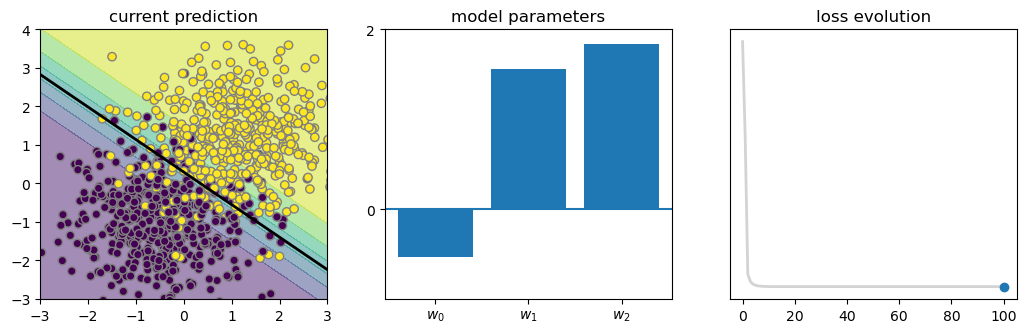

In [36]:
an1.plot_model()

Now try to train another network using SGD. Use only 1 epoch since with SGD, we are updating the weights with every training point (so $n$ times per epoch).

In [29]:
an2 = SingleLayerNeuralNetwork(eta=0.1, rand_seed=13)
print('* init model params: {}'.format(an2.W.tolist()))
an2.fit(X, y, n_epochs=1, method='SGD', save_fig=False)
print('* new model params: {}'.format(an2.W.tolist()))

* init model params: [[-0.712390662050588], [0.753766378659703], [-0.044503078338053455]]
* new model params: [[-0.4652260935631434], [1.0091597014082723], [0.7583320958424151]]


plot the difference in terms of loss evolution using batch or stochastic gradient descent

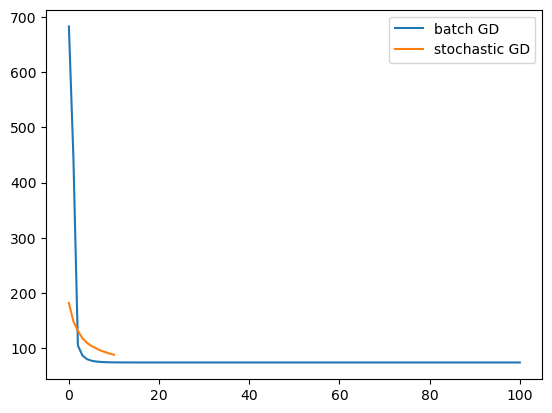

In [30]:
plt.plot(an1.loss_history[:], label='batch GD')
plt.plot(an2.loss_history[::100], label='stochastic GD')
#plt.ylim(0, 2000)
plt.legend()
plt.show()

(-3.0, 3.0)


/tmp/ipykernel_2233614/173825425.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_an[i] = self.predict(np.array([x0, x1]))


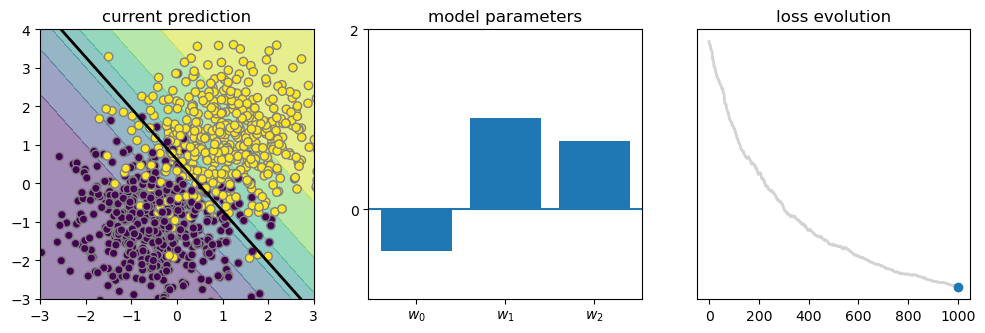

In [31]:
an2.plot_model()

## Logistic regression

Our single layer network using the logistic function for activation is very similar to the logistic regression we saw in a previous tutorial. We can easily compare our result with the logistic regression using `sklearn` toolbox.

In [32]:
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(n_samples=1000, n_features=2, random_state=42, centers=[[-0.5, -1], [1, 1]])
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)
print(log_reg.coef_)
print(log_reg.intercept_)

[[1.5698506  1.81179711]]
[-0.50179977]


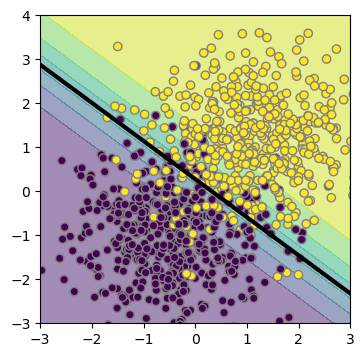

In [33]:
x0, x1 = np.meshgrid(
        np.linspace(-3, 3.1, 62).reshape(-1, 1),
        np.linspace(-3, 4.1, 72).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

plt.figure(figsize=(4, 4))
contour = plt.contourf(x0, x1, zz, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='gray')

# decision boundary
x_bounds = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * x_bounds + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.plot(x_bounds, boundary, "k-", linewidth=3)

plt.xlim(-3, 3)
plt.ylim(-3, 4)
plt.show()